In [1]:
import tensorflow as tf
from convert_to_record import read_and_decode_image

def train_data(images_tfrecord, masks_tfrecord, size=(420, 580)):
    images_queue = tf.train.string_input_producer([images_tfrecord])
    image = read_and_decode_image(images_queue, size)
    
    masks_queue = tf.train.string_input_producer([masks_tfrecord])
    mask = tf.to_float(tf.greater(read_and_decode_image(masks_queue, size)[:,:, 0], 0))
    return image, mask

def preprocess(image):
    # First, the image is essentially grayscale.
    gray_image = tf.image.rgb_to_grayscale(image)
    
    # Then we want to normalize.
    normalized_image = (1.0/255)*(tf.to_float(gray_image) - 127.0)
    
    # We'll likely also want to produce random perturbation of the
    # data to synthetically increase the size of the data set
    # TODO(kjchavez): Add random jitter.
    
    return normalized_image

def batched_train_data(images_tfrecord, masks_tfrecord, batch_size=32, size=(420, 580)):
    image, mask = train_data(images_tfrecord, masks_tfrecord, size=size)
    image = preprocess(image)
    image_batch, mask_batch = tf.train.batch([image, mask], batch_size)
    return image_batch, mask_batch

In [2]:
# The predictive model.

def predict(X):
    """ Produces logits for each pixel in a training image, corresponding to
        the probability that it is part of the sought-after nerve.
    """
    # Allocate variables on GPU.
    with tf.device("/gpu:0"):
        W1 = tf.get_variable("w1", [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.2))
        b1 = tf.get_variable("b1", [32], initializer=tf.constant_initializer(0.0))
        W2 = tf.get_variable("w2", [1, 1, 32, 1], initializer=tf.truncated_normal_initializer(stddev=0.2))
        b2 = tf.get_variable("b2", [1], initializer=tf.constant_initializer(0.0))
        
    conv1 = tf.nn.conv2d(X, W1, strides=(1,1,1,1), padding='SAME', name="conv")
    a1 = tf.nn.relu(tf.nn.bias_add(conv1, b1))
    conv2 = tf.nn.conv2d(a1, W2, strides=(1,1,1,1), padding='SAME', name="net_in_net")
    return tf.squeeze(tf.nn.bias_add(conv2, b2))

def prob(logits):
    output_prob = tf.nn.sigmoid(logits)
    return output_prob

def xentropy_loss(logits, y):
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits, y, name="xentropy_loss")
    return tf.reduce_mean(xentropy)
    

In [3]:
# Build a model
X, y = batched_train_data("train_images.tfrecord", "train_masks.tfrecord")

with tf.variable_scope("model") as scope:
    logits = predict(X)
    y_pred = prob(logits)

loss = xentropy_loss(logits, y)
init_op = tf.initialize_all_variables()

In [5]:
# Run the model
import numpy as np
num_batches = 10
with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    # Do stuff
    print "Starting training."
    for n in xrange(num_batches):
        y_val, y_pred_val, loss_value = sess.run([y, y_pred, loss])
        print loss_value
    
    coord.request_stop()
    coord.join(threads)

Starting training.
0.737397
0.738385
0.738373
0.739011
0.73803
0.738464
0.73972
0.739476
0.739319
0.737215


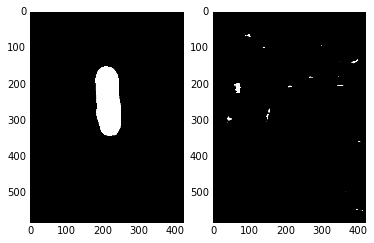

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

t = np.reshape(y_val[1], (580, 420))
t_hat = np.reshape(y_pred_val[1], (580, 420)) > 0.6
plt.subplot(121)
plt.imshow(t, cmap='gray')
plt.subplot(122)
plt.imshow(t_hat.astype(np.float), cmap='gray', clim=(0, 1.0))